## Import Libraries

In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from src import utils
from src.preprocessing import preprocess_data

# For Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from string import ascii_letters

# For Modeling
import sklearn as sk
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
print(f"XGBoost = {xgb.__version__}")
print(f"Sklearn = {sk.__version__}")

# Ensemble and tuning
import optuna
optuna.logging.set_verbosity = optuna.logging.ERROR
print(f"Optuna = {optuna.__version__}")

from warnings import filterwarnings;
filterwarnings('ignore');
pd.set_option("display.max_columns", None)
config = utils.get_config()

XGBoost = 2.1.1
Sklearn = 1.5.1
Optuna = 3.6.1


## Data Preperation

In [2]:
# Train data
train_df = pd.read_csv(config["raw_data"]["path_train"])
train_df = preprocess_data(data=train_df, config=config)

# Test data
test_df = pd.read_csv(config["raw_data"]["path_test"])
test_df = preprocess_data(data=test_df, config=config)

# See the dataset
for name, df in [("Train Data", train_df), ("Test Data", test_df)]:
    print(name)
    display(df.head())

Train Data


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,1,21,1,35,0,1,1,65101,124,187,0
1,1,43,1,28,0,2,1,58911,26,288,1
2,0,25,1,14,1,0,0,38043,152,254,0
3,0,35,1,1,0,1,1,2630,156,76,0
4,0,36,1,15,1,1,0,31951,152,294,0


Test Data


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
11504798,0,20,1,47,0,0,0,2630,160,228
11504799,1,47,1,28,0,1,1,37483,124,123
11504800,1,47,1,43,0,1,1,2630,26,271
11504801,0,22,1,47,1,0,0,24502,152,115
11504802,1,51,1,19,0,1,0,34115,124,148


## Descriptive Statistics

In [3]:
# Quick check
utils.initial_check(train_df)

,Column,Type,Null Count,Unique Count,Min,Max
0,Gender,int8,0,2,0,1
1,Age,int8,0,66,20,85
2,Driving_License,int8,0,2,0,1
3,Region_Code,int8,0,53,0,52
4,Previously_Insured,int8,0,2,0,1
5,Vehicle_Age,int8,0,3,0,2
6,Vehicle_Damage,int8,0,2,0,1
7,Annual_Premium,int32,0,51728,2630,540165
8,Policy_Sales_Channel,int16,0,152,1,163
9,Vintage,int16,0,290,10,299


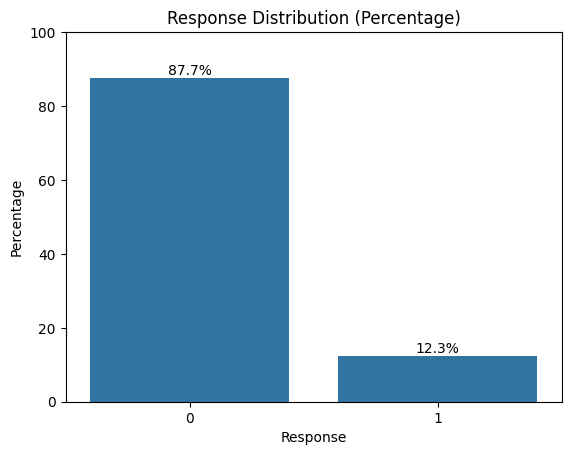

In [4]:
## Target distribution
# Calculate percentages
response_counts = train_df["Response"].value_counts()
response_percentages = response_counts / len(train_df) * 100

# Create the bar plot
ax = sns.barplot(x=response_percentages.index, y=response_percentages.values)

# Customize the y-axis to show percentages
ax.set_ylabel("Percentage")
ax.set_ylim(0, 100)  # Set y-axis range from 0 to 100%

# Add percentage labels on top of each bar
for i, v in enumerate(response_percentages.values):
    ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom')

plt.title("Response Distribution (Percentage)")
plt.show()

## EDA

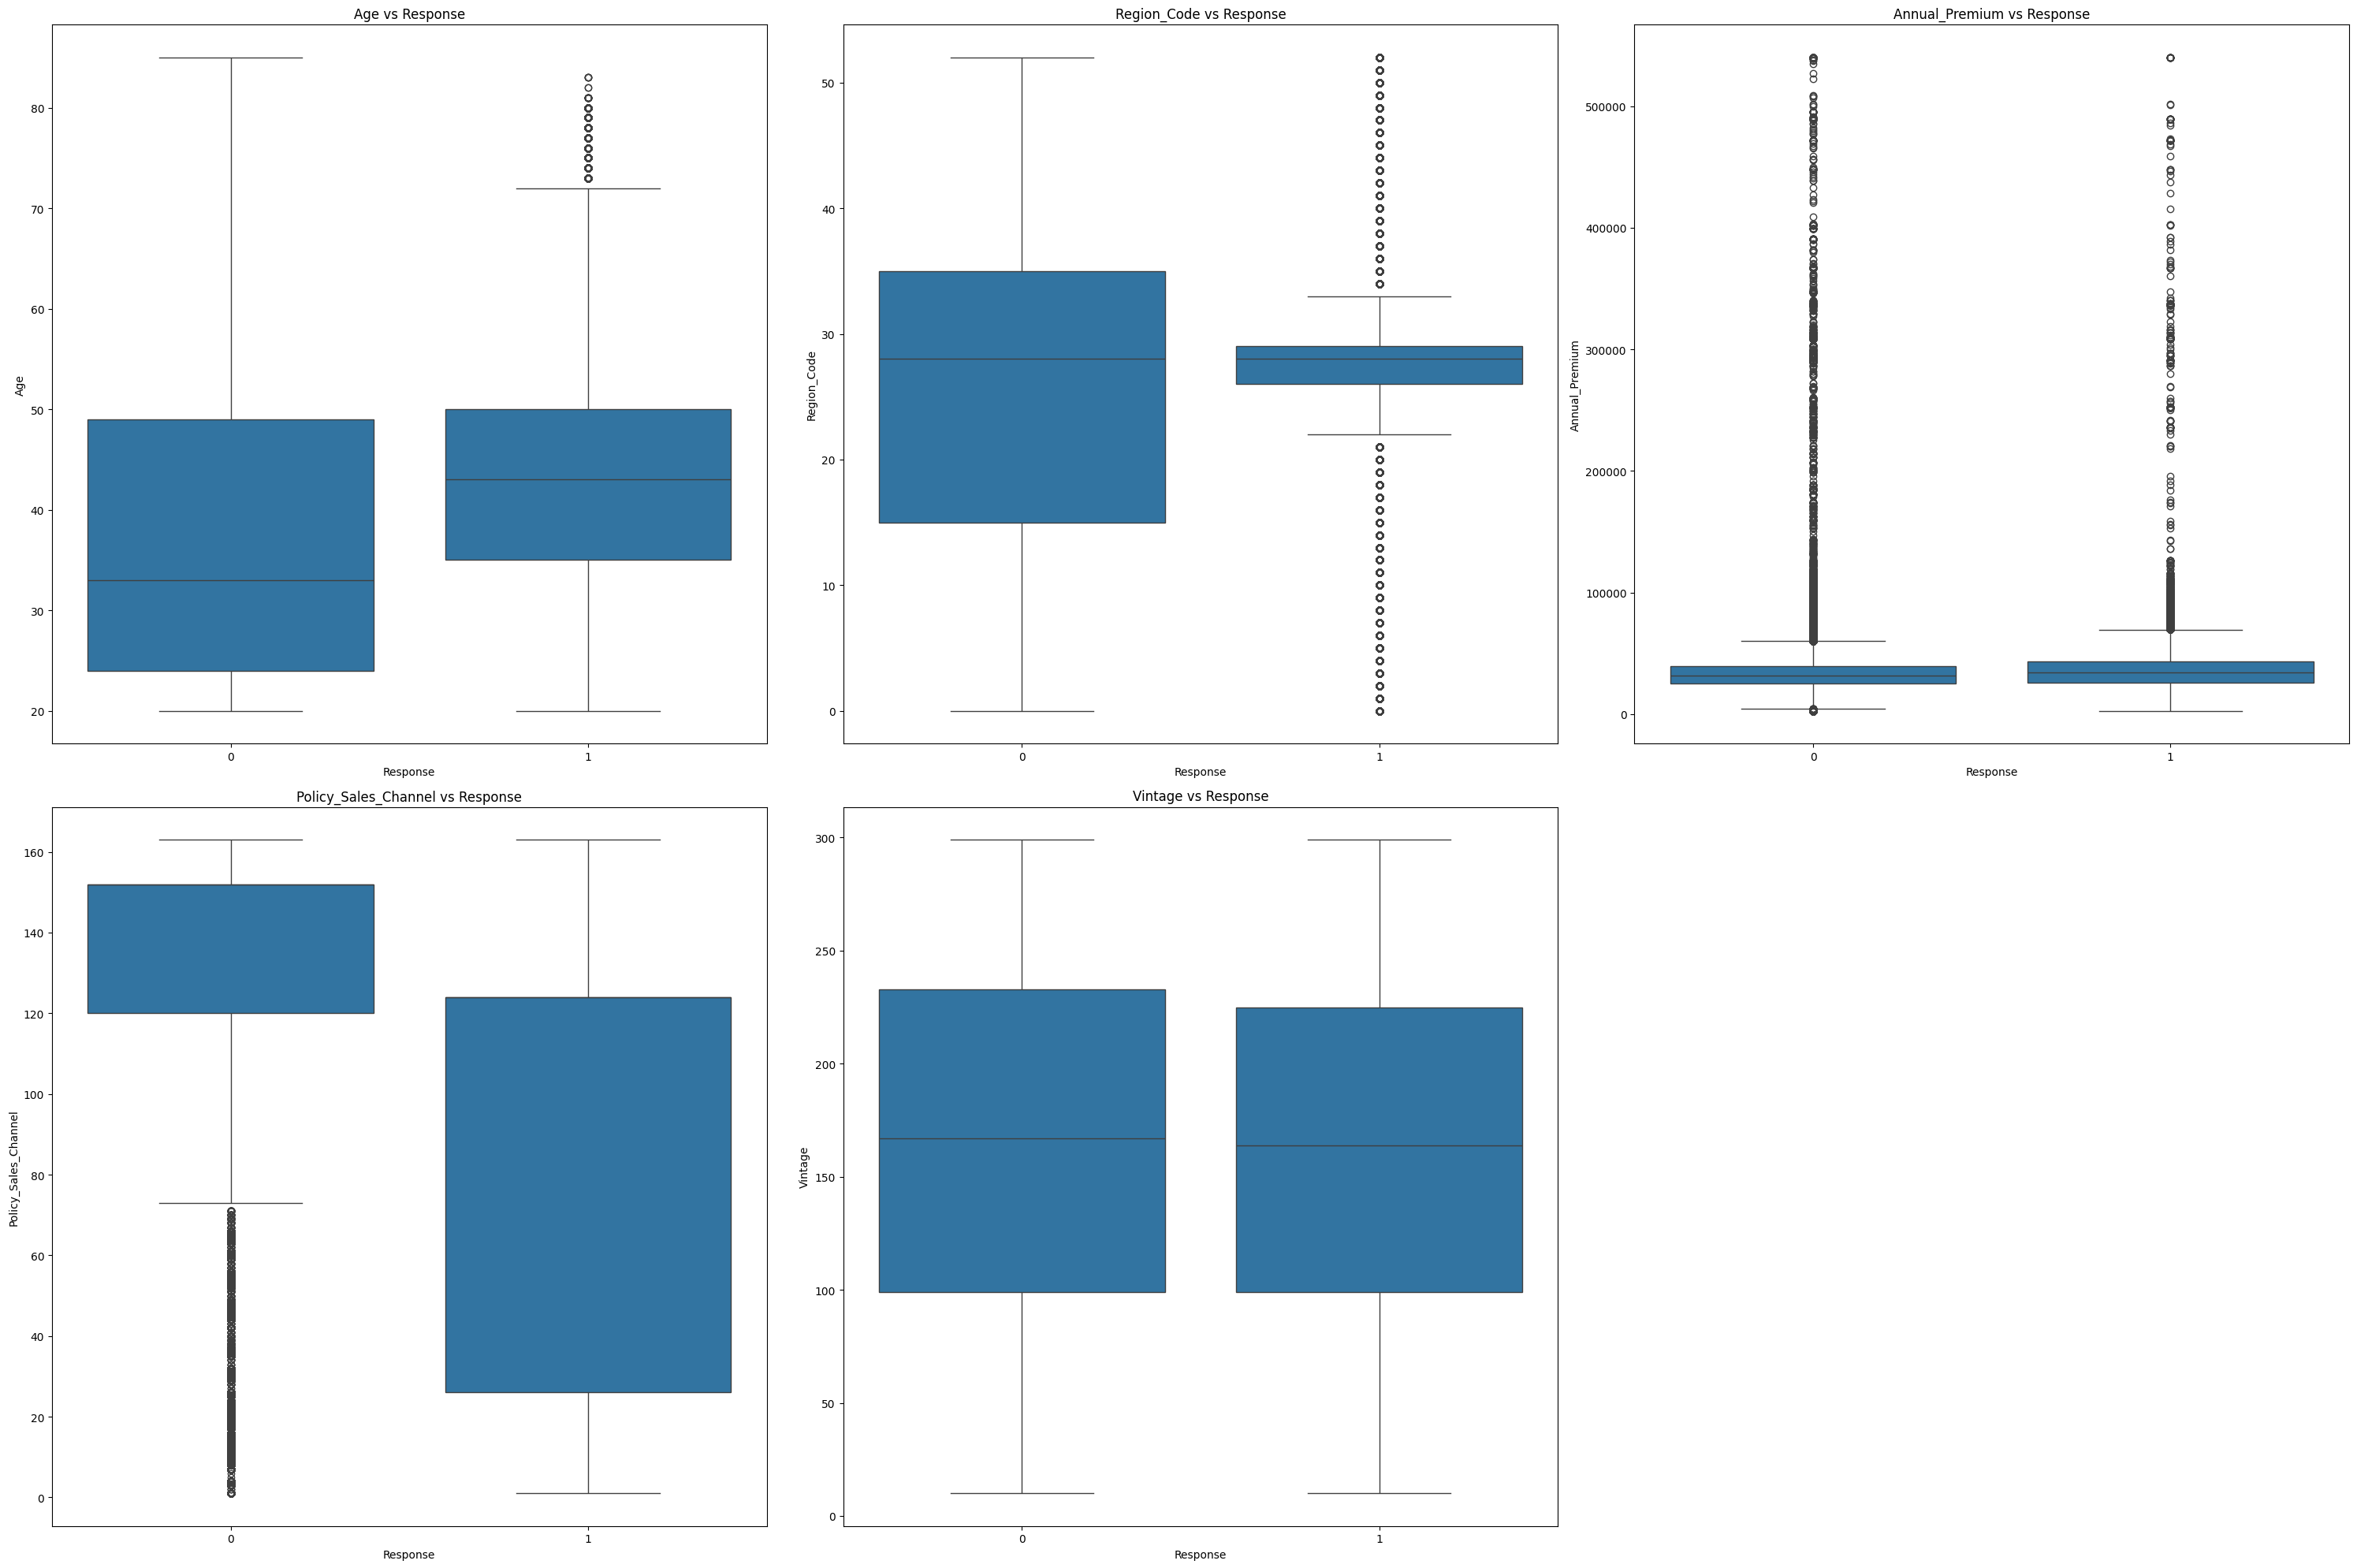

In [5]:
# See Response vs Continuos Columns
def plot_boxplots(df, response_col, cols, figsize=(30, 20)):
    n_cols = 3
    n_rows = (len(cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        sns.boxplot(x=response_col, y=col, data=df, ax=ax)
        ax.set_title(f'{col} vs {response_col}')
        ax.set_xlabel(response_col)
        ax.set_ylabel(col)

    # Remove any unused subplots
    for ax in axes[len(cols):]:
        ax.remove()

    plt.tight_layout()
    return fig

# Usage
fig = plot_boxplots(train_df, 'Response', config["raw_data"]["continuous_cols"])
plt.show()

<Axes: >

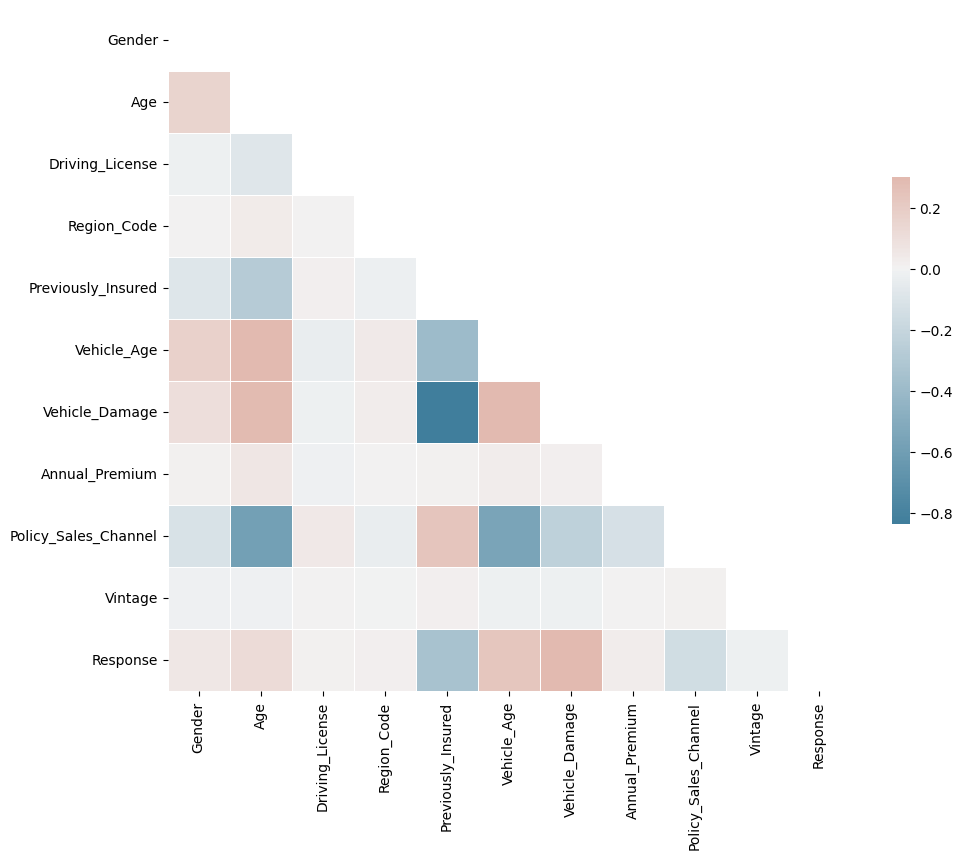

In [6]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Engineering

In [7]:
# Maybe after first base line run

## Modeling

### Baseline Model

In [9]:
# Baseline model using Logistic Regression CV (Before Feature Engineering)
X = train_df[config['feature_cols']]
y = train_df[config['target_cols']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = model.predict(X_test)

target_names = ['REJECT', 'MONEY MONEY MONEY']
print(classification_report(y_test, y_pred, target_names=target_names))

c:\Users\madeba072283\.conda\envs\base-project\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\madeba072283\.conda\envs\base-project\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

                   precision    recall  f1-score   support

           REJECT       0.88      1.00      0.93   2522560
MONEY MONEY MONEY       0.41      0.01      0.02    353640

         accuracy                           0.88   2876200
        macro avg       0.64      0.50      0.48   2876200
     weighted avg       0.82      0.88      0.82   2876200



#### Baseline Model Performance

The baseline model achieves an overall accuracy of **0.88**.

##### Precision
- **REJECT**: 0.88 (88%)
- **MONEY MONEY MONEY**: 0.41 (41%)

The model is effective at predicting the "REJECT" class but struggles with "MONEY MONEY MONEY".

##### Recall
- **REJECT**: 1.00 (100%)
- **MONEY MONEY MONEY**: 0.01 (1%)

The recall for "REJECT" is perfect, indicating strong performance for this class. However, the model fails to detect the "MONEY MONEY MONEY" class, as shown by the extremely low recall.

##### F1-Score
- **REJECT**: 0.93
- **MONEY MONEY MONEY**: 0.02

The low F1-score for "MONEY MONEY MONEY" indicates poor performance in predicting this class.

#### Conclusion
- The model effectively predicts the majority "REJECT" class but performs poorly for the minority "MONEY MONEY MONEY" class.
- The high accuracy is mainly due to the class imbalance.
- Consider techniques like resampling, adjusting class weights, or exploring models better suited for imbalanced data to improve performance on the minority class.